<a href="https://colab.research.google.com/github/gc2321/3546-Deep-Learning/blob/main/pytorch/2_1_RNN_sine_wave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Create a sine wave dataset

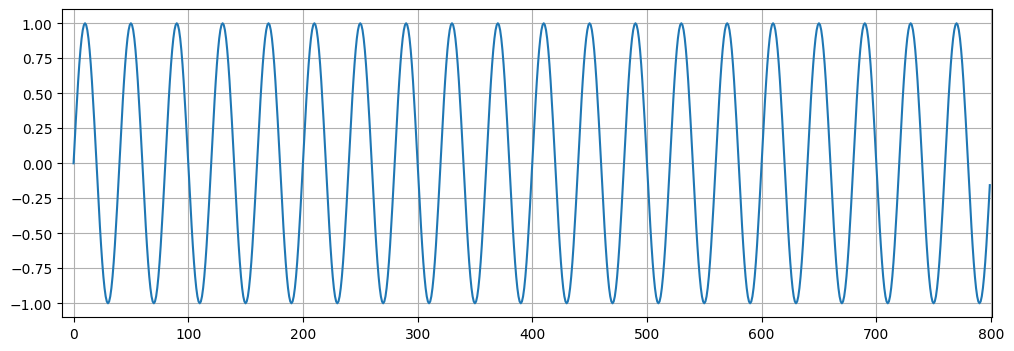

In [3]:
x = torch.linspace(0,799,steps=800)
y = torch.sin(x*2*3.1416/40)

plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.plot(y.numpy());

## Create train and test sets

In [4]:
test_size = 40

train_set = y[:-test_size]
test_set = y[-test_size:]

## Prepare the training data

In [5]:
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [6]:
# From above:
# test_size = 40
# train_set = y[:-test_size]
# test_set = y[-test_size:]

window_size = 40

# Create the training dataset of sequence/label tuples:
train_data = input_data(train_set,window_size)

len(train_data) # this should equal 760-40

720

In [7]:
# Display the first (seq/label) tuple in train_data
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
          7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
         -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
 tensor([1.4480e-05]))

In [8]:
torch.set_printoptions(sci_mode=False) # to improve the appearance of tensors
train_data[0]

(tensor([     0.0000,      0.1564,      0.3090,      0.4540,      0.5878,
              0.7071,      0.8090,      0.8910,      0.9511,      0.9877,
              1.0000,      0.9877,      0.9511,      0.8910,      0.8090,
              0.7071,      0.5878,      0.4540,      0.3090,      0.1564,
             -0.0000,     -0.1564,     -0.3090,     -0.4540,     -0.5878,
             -0.7071,     -0.8090,     -0.8910,     -0.9511,     -0.9877,
             -1.0000,     -0.9877,     -0.9511,     -0.8910,     -0.8090,
             -0.7071,     -0.5878,     -0.4540,     -0.3090,     -0.1564]),
 tensor([    0.0000]))

## Define an LSTM model

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size

        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)

        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,out_size)

        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,hidden_size),
                       torch.zeros(1,1,hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]   # we only care about the last prediction